So need a function to calculate the attenuation coefficient for a given frequency, temperature and relative humidity. And pressure? Right now we are about 2 orders of magnitude off in the PyCharm workbook.

Could use the Stoke's equation for this. Also ISO 9613 apparently describes equations for calculating the attenuation coefficient for PURE tones. It will be different for the different frequency components, but since this is an indicator it should be okay.

https://www.sciencedirect.com/topics/engineering/acoustic-propagation

file:///Users/harryhorsley/Downloads/Humidity_Conversion_Formulas.pdf

In [14]:
import numpy as np
def humid(temp_deg, rel_humid):
    vapor_pressure = 1000 * 0.61121 * np.exp((18.678 - temp_deg / 234.5) * (
            temp_deg / (257.14 + temp_deg)))  # Approximate vapor_pressure with the Buck equation

    p_v = rel_humid / 100 * vapor_pressure

    p_d = 1.013e5 - p_v

    density_humid = (p_d * 0.028966 + p_v * 0.018016) / 8.314 / (temp_deg + 273.15)

    abs_humidity_frac = 0.01 * rel_humid * vapor_pressure / 1.013e5  # Absolute humidity value based on temperature (for vapor pressure) and relative humidity
    
    abs_humidity_percent = abs_humidity_frac*100
    
    return abs_humidity_frac, abs_humidity_percent, density_humid

def rel2absolute(temp_deg, rel_humid):
    
    O = 1 - (temp_deg + 273.15) / 647.096
    
    p_a = 1.01325e5
            
    p_sat = 10 * 2206400 * np.exp(647.096 / (temp_deg + 273.15) * (-7.85951783*O + 1.84408259*O**1.5 + -11.7866497*O**3 + 22.6807411*O**3.5 + -15.9618719*O**4 + 1.80122502*O**7.5))
    print(p_sat)
    
    return rel_humid * p_sat / p_a

In [4]:
rel2absolute(20, 100)


2339.1937366227544


2.3086047240293652

In [5]:
humid(20, 100)

(0.023083316667818547, 2.3083316667818545, 1.1934155508503306)

Now moving onto PDF from the university.

Sound propagation and divergence we have the normal equation.

Adds in Directivity Index!! And does it quite nicely

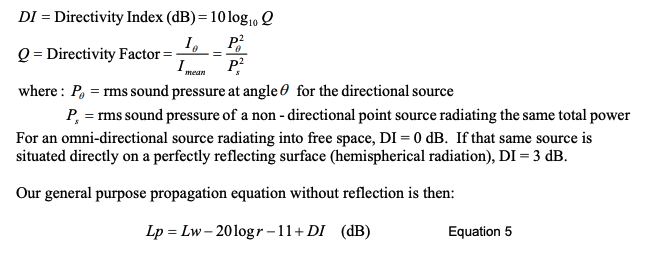

Moving onto Excess Attenuation (that above spherical divergence and atmospheric absorption) we can add to the equation 5 above as so:

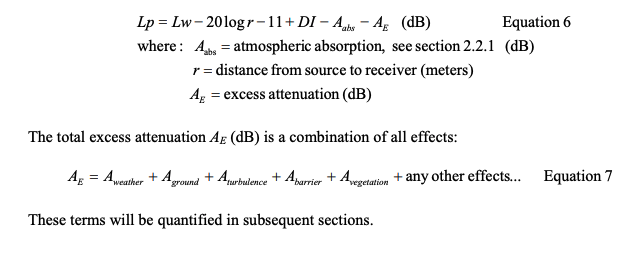



In [35]:
#Atmospheric absorption, alpha

#Ref temperature 20 degrees Celsius
T_0 = 293.15
#Ref pressure of atmospheric
P_0 = 1.01325e5

freq = 10000

temp_deg = 293.15
T = temp_deg
press = 1.01325e5
rel_humid = 70
frac, h, density = humid(temp_deg - 273.15, rel_humid)
h = rel2absolute(temp_deg-273.15,rel_humid)

F_0 = (press/P_0)*(24 + 4.41e4*h*(12*(0.05 + h)/0.391 + h))
F_N = (press/P_0)*(9 + 200*h)

# In dB/m
alpha_cr = 15.895e-11 * (temp_deg/T_0)**0.5 / (press/ P_0) * freq**2

alpha_vib_1 = 1.11e-1*np.exp(-2239.1/temp_deg)/(F_0 + freq**2/F_0) * (T_0/temp_deg)**(-5/2) * freq**2

alpha_vib_2 = 9.48e-1*np.exp(-3352./temp_deg)/(F_N + freq**2/F_N) * freq**2

alpha1 = alpha_cr + alpha_vib_1 + alpha_vib_2

f_0 = 24 + 4.04e4 * h * (0.02 + h) / (0.391 + h)
f_N = (T/T_0)**-0.5 * (9 + 280 * h * np.exp(-4.17*((T/T_0)**(-1/3) - 1)))


alpha = 869 * freq**2 * (1.84e-11 * (T / T_0)**0.5 + (T/T_0)**(-5/2) * (0.01275 * np.exp(-2239.1/T) / (f_0 + freq**2/f_0) + 0.1068 * np.exp(-3352/T) / (f_N + freq**2/f_N)))

2339.1937366227544


In [36]:
alpha1

0.0207202751750312

In [37]:
alpha

11.744943521656298

For an actual distance, x, to calculate the range we use

In [94]:
x=1
A_abs = alpha*x/100
A_abs

0.000217119440752169

# Meteorological conditions

**Wind**

Friction between air and ground creates gradients. Strongly dependent on time of day, weather and surface conditions. Typicall speed varies logarithmically up to a height of 30 to 100m (without turbulence). This can cause refraction and shadow zones going upwind.

**Temperature**

A neutral atmosphere is one that decreases at the dry adiabatic rate (-0.98/100m). Gradients greater than this are superadiabatic and will cause more shadow zones (below). Determining excess attenuation is not easy, can use RAY TRACING? (speed of sound as a function of altitude)

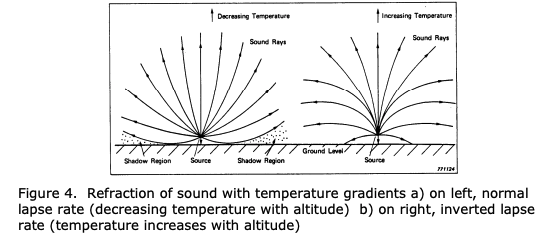

**Humidity**

Gradients are not common in the atmosphere

# Ground interaction

Ground surface can  never be perfectly rigid or totally reflective (Except open water, ice or concrete). Reflective waves can destructively or constructively interfere, which is why we want a direction.

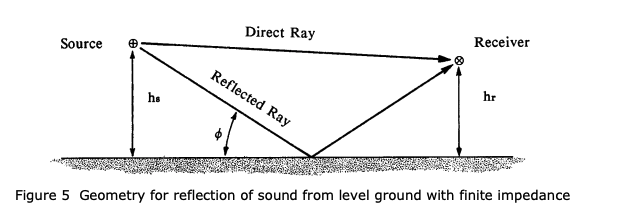

In [36]:
# Trying to get this to return a numpy array
def humid2(temp_deg, rel_humid):
    
    temp_deg = np.array(temp_deg, dtype=np.float64)
    rel_humid = np.array(rel_humid, dtype=np.float64)
    
    vapor_pressure = 1000 * 0.61121 * np.exp((18.678 - temp_deg / 234.5) * (
            temp_deg / (257.14 + temp_deg)))  # Approximate vapor_pressure with the Buck equation

    p_v = rel_humid / 100 * vapor_pressure

    p_d = 1.013e5 - p_v

    density_humid = (p_d * 0.028966 + p_v * 0.018016) / 8.314 / (temp_deg + 273.15)

    abs_humidity_frac = 0.01 * rel_humid * vapor_pressure / 1.013e5  # Absolute humidity value based on temperature (for vapor pressure) and relative humidity
    
    abs_humidity_percent = abs_humidity_frac*100
    
    return abs_humidity_frac, abs_humidity_percent, density_humid

In [40]:
print(humid(20,80))
humid2([20,30],[30,20])

(0.01846665333425484, 1.846665333425484, 1.1955166756605953)


(array([0.006925  , 0.00838129]),
 array([0.6924995 , 0.83812946]),
 array([1.20076949, 1.16051882]))

In [78]:
def saturation_pressure_water(temp_deg):
    """Returns the saturation concentration of water vapour at a specific tempreature using ISO 9613"""

    return (4.6151 - 6.8346 * (273.16/(temp_deg + 273.15))**1.261)

def molar_concentration_water(temp_deg, RH, pressure = 1.01325e5):
    """Returns the absolute molar concentration of water vapour in air for a given temperature,
    pressure and relative humidity"""

    C = saturation_pressure_water(temp_deg)
    
    return RH * (10**C) / pressure * 1.01325e5

In [79]:

print(humid(20,80))
molar_concentration_water(20, 80)

(0.01846665333425484, 1.846665333425484, 1.1955166756605953)


1.8448599678074673

# ISO 1993 Standard Functions

In [53]:
def pressure_at_x_in_Pa(initial_pressure, x, temp_deg=20, freq = 5e3, RH = 80, pressure = 1.01325e5):
    """Returns the pressure (Pa) at a distance x given initial pressures, temperatures frequencies and RH"""
    
    initial_pressure = np.array(initial_pressure, dtype=np.float64)
    freq = np.array(freq, dtype=np.float64)
    temp_deg = np.array(temp_deg, dtype=np.float64)
    RH = np.array(RH, dtype=np.float64)
    pressure = np.array(pressure, dtype=np.float64)
    
    alpha = attenuation_coefficient_dBperm(freq, temp_deg, RH, pressure = 1.01325e5)
    
    scale_factor_from_dB = 1 / (20 * np.log10(np.e))
    
    return initial_pressure * np.exp(- x * alpha * scale_factor_from_dB)

def abs_coeff_from_pressures(initial_pressure, final_pressure, x):
    
    return 20 * np.log10(initial_pressure / final_pressure) / x


1.8448599678074675

In [70]:
pressure_at_x_in_Pa(1.01555e5, 1)

NameError: name 'attenuation_coefficient_dBperm' is not defined